In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
truth_poses = pd.read_csv('dataset_visual/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', truth_poses.shape)

Shape of position dataframe: (4541, 12)


In [3]:
#reshaping ground truth poses
gt = np.zeros((len(truth_poses), 3, 4))

for i in range(len(truth_poses)):
    gt[i] = np.array(truth_poses.iloc[i]).reshape((3, 4))

<IPython.core.display.Javascript object>


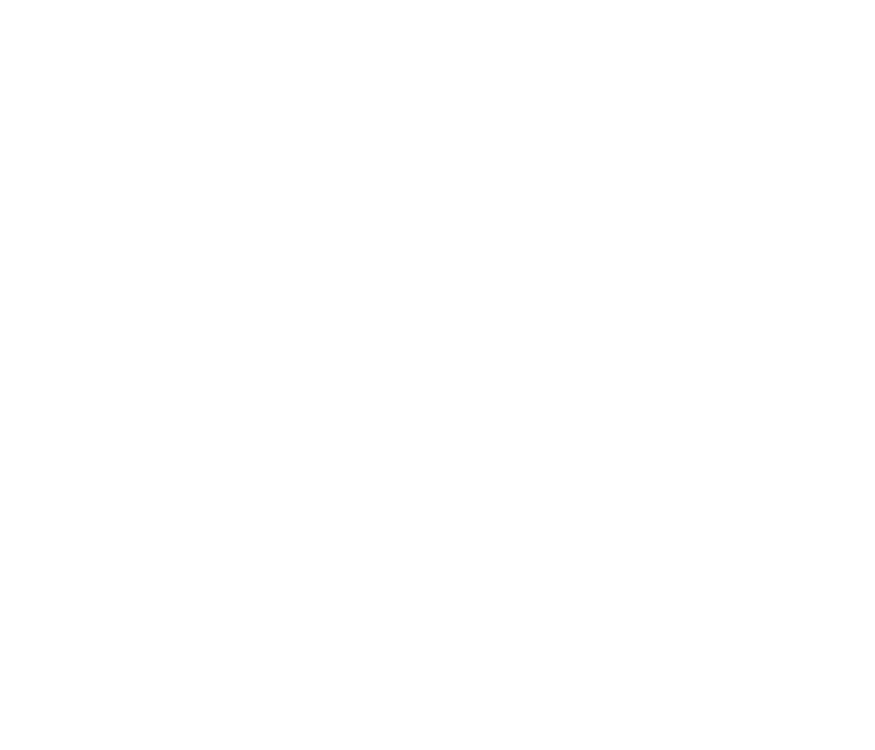

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

In [5]:
#Class for handling interative forward files

class Dataset_Handler():
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        
        self.lidar = lidar
        
        # Set file paths
        self.seq_dir_vis = 'dataset_visual/sequences/{}/'.format(sequence)
        self.seq_dir_lid = 'dataset_lidar/sequences/{}/'.format(sequence)
        self.poses_dir = 'dataset_visual/poses/{}.txt'.format(sequence)
        
        self.low_memory = low_memory
        
        # Get ground truth poses
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir_vis + 'image_0')
        self.right_image_files = os.listdir(self.seq_dir_vis + 'image_1')
        self.velodyne_files = os.listdir(self.seq_dir_lid + 'velodyne')
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir_lid + 'velodyne/'
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir_vis + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
#         self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
#         self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        
        #Transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times
        self.times = np.array(pd.read_csv(self.seq_dir_vis + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        
        # Ground truth poses
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Will use generators to provide data sequentially to save RAM
        # Use class method to set up generators
        self.reset_frames()
        
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.seq_dir_vis + 'image_0/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir_vis + 'image_1/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir_vis + 'image_0/' 
                                           + self.left_image_files[1], 0)
        if self.lidar:
            self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                dtype=np.float32, 
                                                count=-1).reshape((-1, 4))
            
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]

    
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir_vis + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir_vis + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass


In [46]:
# Testing for sequence '00'
handler = Dataset_Handler('02')

In [47]:
# Compute left disparity
def compute_left_disparity_map(img_left, img_right, matcher='sgbm', verbose=False):
    
    # Defining parameters
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
        
    if matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)

    return disp_left

Time to compute disparity map using StereoSGBM: 0:00:00.050540


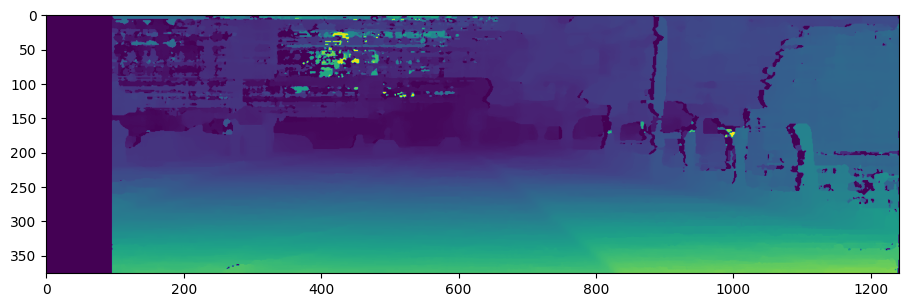

In [48]:
%matplotlib inline

# We use StereoSGBM for comparison
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [49]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [50]:
# Estimating depth from an incoming set of stereo images

def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', verbose=False, 
                   rectified=True):
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth


In [51]:
#Feature extraction function using SIFT

def extract_features(image, detector='sift', mask=None):
    if detector == 'sift':
        det = cv2.SIFT_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [52]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        
        matches = matcher.knnMatch(des1, des2, k=k)
    
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [53]:
def filter_matches_distance(matches, dist_threshold):
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [54]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Time to compute disparity map using StereoSGBM: 0:00:00.048092
Number of matches before filtering: 1684
Number of matches after filtering: 179


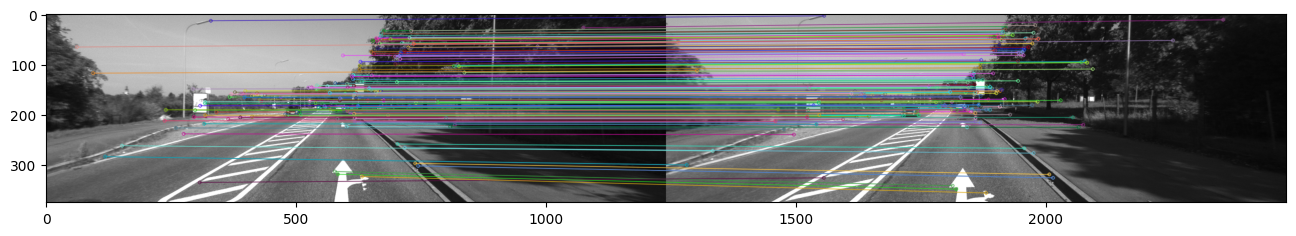

In [55]:
# Now to see the difference with 'sgbm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left

depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)

kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')

matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)

print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)

print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [56]:
# For LIDER mapping
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    # We know the lidar X axis points forward, we need nothing behind the lidar, so we
    # ignore anything with a X value less than or equal to zero
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    
    # We do not need reflectance info, so drop last column and replace with ones to make
    # coordinates homogeneous for tranformation into the camera coordinate frame
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform pointcloud into camera coordinate frame
    cam_xyz = Tr.dot(pointcloud.T)
    
    # Ignore any points behind the camera (probably redundant but just in case)
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    # Extract the Z row which is the depth from camera
    depth = cam_xyz[2].copy()
    
    # Project coordinates in camera frame to flat plane at Z=1 by dividing by Z
    cam_xyz /= cam_xyz[2]
    
    # Add row of ones to make our 3D coordinates on plane homogeneous for dotting with P0
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    
    # Get pixel coordinates of X, Y, Z points in camera coordinate frame
    projection = P0.dot(cam_xyz)
    #projection = (projection / projection[2])
    
    # Turn pixels into integers for indexing
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    #pixel_coordinates = np.array(pixel_coordinates)
    
    # Limit pixel coordinates considered to those that fit on the image plane
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0)
                      )
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    
    # Establish empty render image, then fill with the depths of each point
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
    # Fill zero values with large distance so they will be ignored. (Using same max value)
    render[render == 0.0] = 3861.45
    
    return render

Time to compute disparity map using StereoSGBM: 0:00:00.048683


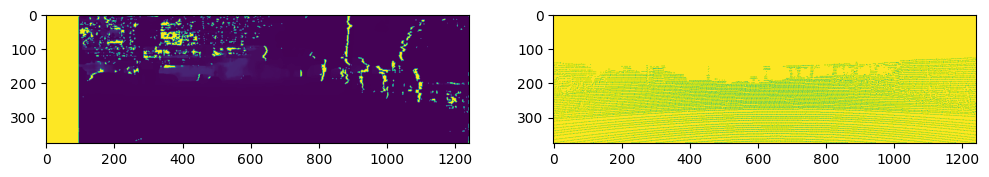

In [57]:
# Now a side-by-side comparison of the stereo depth vs lidar depth maps
depth_stereo = stereo_2_depth(image_left, 
                             image_right, 
                             handler.P0, 
                             handler.P1,
                             matcher='sgbm',
                             verbose=True)

depth_lidar = pointcloud2image(handler.first_pointcloud, handler.imheight, handler.imwidth,
                               handler.Tr, handler.P0
                              )
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(depth_stereo)
ax2.imshow(depth_lidar)

In [58]:
# Let's look at the maximum real depth returned from the lidar scan
depth_lidar[depth_lidar < 3861.45].max()

79.6588489444402

In [59]:
%matplotlib notebook

<IPython.core.display.Javascript object>


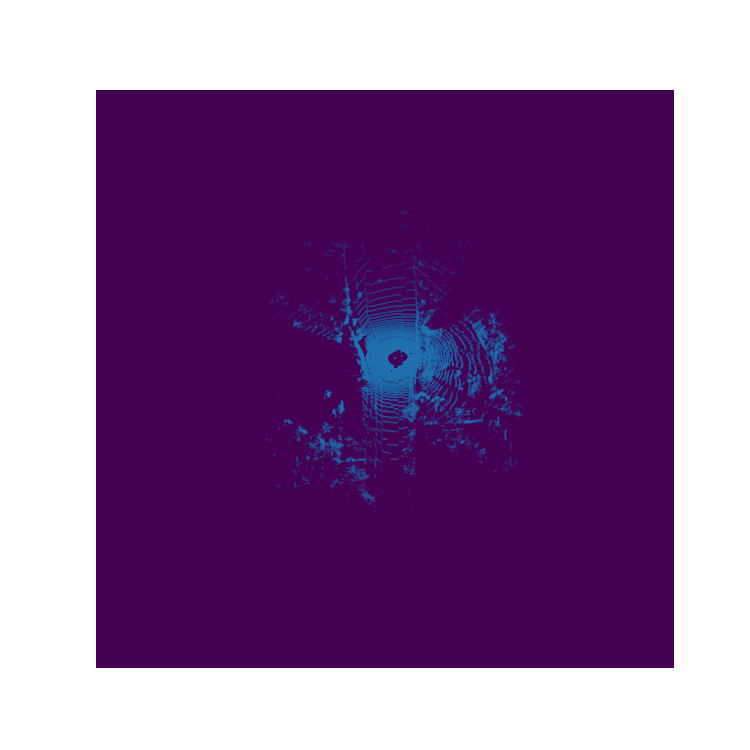

In [60]:
# Visualizing a lidar pointcloud with matplotlib.
pointcloud = handler.first_pointcloud
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
ys = pointcloud[:, 1]#[::20]
zs = pointcloud[:, 2]#[::20]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=40, azim=180)



In [61]:
# Let's determine the amount of image area that the lidar has given us depth information for
lidar_coverage = depth_lidar[depth_lidar < depth_lidar.max()].size / depth_lidar.size
print('Lidar Coverage: {}%'.format(np.round(lidar_coverage, 2)*100))

Lidar Coverage: 4.0%


In [62]:
# A side by side comparison of the depths from stereo estimation and our lidar cloud
idx_height, idx_width = np.where(depth_lidar < 3000)
depth_indx = np.array(list(zip(idx_height, idx_width)))

comparison = np.hstack([depth_stereo[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1), 
                        depth_lidar[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1)
                       ])
for i, row in enumerate(comparison):
    print('location:', depth_indx[i], 'stereo/lidar depth:', row)
    if i > 100:
        break

location: [ 127 1220] stereo/lidar depth: [12.53208276 11.82472166]
location: [ 127 1224] stereo/lidar depth: [12.53208276 11.83043835]
location: [ 127 1228] stereo/lidar depth: [12.45628387 12.30383734]
location: [ 128 1207] stereo/lidar depth: [13.14535489 12.46581184]
location: [ 128 1210] stereo/lidar depth: [12.87149333 12.42755454]
location: [ 128 1214] stereo/lidar depth: [12.73879753 12.44825056]
location: [ 128 1216] stereo/lidar depth: [12.6088098  12.33368438]
location: [ 128 1232] stereo/lidar depth: [12.45628387 12.63933096]
location: [ 128 1235] stereo/lidar depth: [12.45628387 13.07676327]
location: [ 128 1239] stereo/lidar depth: [12.43122093 13.37027506]
location: [ 129 1171] stereo/lidar depth: [13.00698274 12.67090896]
location: [ 129 1175] stereo/lidar depth: [13.03442363 12.68862293]
location: [ 129 1179] stereo/lidar depth: [13.06198055 12.62237577]
location: [ 129 1186] stereo/lidar depth: [12.84473347 12.78569539]
location: [ 129 1190] stereo/lidar depth: [12.87

In [63]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [64]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
        # in the last frame run.
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        # Stop if we've reached the second to last frame, since we need two sequential frames
        #if i == num_frames - 1:
        #    break
        # Start timer for frame
        start = datetime.datetime.now()
        # Get our stereo images for depth estimation
        if handler.low_memory:
            image_left = image_plus1
            image_right = next(handler.images_right)
            # Get next frame in the left camera for visual odometry
            image_plus1 = next(handler.images_left)
        else:
            image_left = handler.images_left[i]
            image_right = handler.images_right[i]
            # Get next frame in the left camera for visual odometry
            image_plus1 = handler.images_left[i+1]
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None
            
        # Supercede stereo depth estimations where lidar points are available
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            lidar_depth = pointcloud2image(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            indices = np.where(lidar_depth < 3000)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        
        # The following code is commented out because it is only necessary if you intend to
        # use very low distance ratios for match filtering. Feel free to uncomment and try
        # out using very low distance ratios, but if you do, comment out the above line.
        # Try to get motion with filter distance, if not increase threshold until success
        #try:
        #    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                           kp0, 
        #                                                           kp1, 
        #                                                           k_left, 
        #                                                           depth)
        #except:
        #    filt_inc = 0.1
        #    while True:
        #        print('Not enough features after filter with threshold {},'.format(filter_match_distance),
        #              'raising threshold to {} until next frame.'.format(filter_match_distance + filt_inc)) 
        #        try:
        #            matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
        #            rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
        #                                                                   kp0, 
        #                                                                   kp1, 
        #                                                                   k_left, 
        #                                                                   depth)
        #            break
        #        except:
        #            filt_inc += 0.1
        #            continue
                  
        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        # Place resulting rotation matrix  and translation vector in their proper locations
        # in homogeneous T matrix
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        # The SolvePnPRansac() function computes a pose that relates points in the global
        # coordinate frame to the camera's pose. We used the camera's pose in the first image
        # as the global coordinate frame, reconstruct 3D positions of the features in the
        # image using stereo depth estimation, then find a pose which relates the camera in
        # the next frame to those 3D points. When tracking the vehicle pose over time, what we
        # actually want is to relate the points in the camera's coordinate frame to the global
        # frame, so we want the opposite (inverse) of the transformation matrix provided to us
        # by the SolvePnPRansac function. Recall from the earlier discussion that we can find
        # the inverse of a transformation matrix by making it homogeneous by adding a row of
        # (0, 0, 0, 1) to it, then taking its inverse. Further, we are tracking the vehicle
        # motion from the very first camera pose, so we need the cumulative product of the
        # inverses of each estimated camera pose given to us by SolvePnPRansac. Thus, below
        # we iteratively multiply the T_tot homogeneous transformation matrix that we 
        # instantiated before the for loop by the inverse of each successive pose we estimate,
        # and save its current values into our estimated poses at an index corresponding to our
        # current frame. This way, the transformation matrix at each index will be one that
        # relates 3D homogeneous coordinates in the camera's frame to the global coordinate
        # frame, which is the coordinate frame of the camera's first position. The translation
        # vector component of this transformation matrix will describe where the camera's curent
        # origin is in this global referece frame.
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [65]:
def calculate_error(ground_truth, estimated, error_type='mse'):

    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[:, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[:, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[:, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[:, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[:, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[:, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}


In [66]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);


In [67]:
# See what kind of results we get without using LIDAR correction on depth
# We will use StereoBM to do depth estimate, since it is faster than StereoSGBM, then compare
handler.lidar = False
start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift',
                                        #matching='FLANN',
                                        stereo_matcher='sgbm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.224536
Time to compute frame 2: 0:00:00.165495
Time to compute frame 3: 0:00:00.182353
Time to compute frame 4: 0:00:00.172926
Time to compute frame 5: 0:00:00.181857
Time to compute frame 6: 0:00:00.167664
Time to compute frame 7: 0:00:00.206050
Time to compute frame 8: 0:00:00.157336
Time to compute frame 9: 0:00:00.175214
Time to compute frame 10: 0:00:00.171714
Time to compute frame 11: 0:00:00.174428
Time to compute frame 12: 0:00:00.173110
Time to compute frame 13: 0:00:00.190152
Time to compute frame 14: 0:00:00.156736
Time to compute frame 15: 0:00:00.174087
Time to compute frame 16: 0:00:00.173501
Time to compute frame 17: 0:00:00.174356
Time to compute frame 18: 0:00:00.173025
Time to compute frame 19: 0:00:00.200193
Time to compute frame 20: 0:00:00.173824
Time to compute frame 21: 0:00:00.189660
Time

Time to compute frame 196: 0:00:00.221018
Time to compute frame 197: 0:00:00.221169
Time to compute frame 198: 0:00:00.230514
Time to compute frame 199: 0:00:00.213455
Time to compute frame 200: 0:00:00.230362
Time to compute frame 201: 0:00:00.212690
Time to compute frame 202: 0:00:00.189414
Time to compute frame 203: 0:00:00.204097
Time to compute frame 204: 0:00:00.188658
Time to compute frame 205: 0:00:00.205328
Time to compute frame 206: 0:00:00.188314
Time to compute frame 207: 0:00:00.182111
Time to compute frame 208: 0:00:00.188222
Time to compute frame 209: 0:00:00.181581
Time to compute frame 210: 0:00:00.188094
Time to compute frame 211: 0:00:00.189323
Time to compute frame 212: 0:00:00.186775
Time to compute frame 213: 0:00:00.209651
Time to compute frame 214: 0:00:00.191303
Time to compute frame 215: 0:00:00.178193
Time to compute frame 216: 0:00:00.197559
Time to compute frame 217: 0:00:00.170214
Time to compute frame 218: 0:00:00.172853
Time to compute frame 219: 0:00:00

Time to compute frame 392: 0:00:00.236816
Time to compute frame 393: 0:00:00.239175
Time to compute frame 394: 0:00:00.254923
Time to compute frame 395: 0:00:00.281906
Time to compute frame 396: 0:00:00.275642
Time to compute frame 397: 0:00:00.241246
Time to compute frame 398: 0:00:00.268149
Time to compute frame 399: 0:00:00.236797
Time to compute frame 400: 0:00:00.222936
Time to compute frame 401: 0:00:00.291214
Time to compute frame 402: 0:00:00.227149
Time to compute frame 403: 0:00:00.229721
Time to compute frame 404: 0:00:00.250445
Time to compute frame 405: 0:00:00.248309
Time to compute frame 406: 0:00:00.276899
Time to compute frame 407: 0:00:00.242530
Time to compute frame 408: 0:00:00.233620
Time to compute frame 409: 0:00:00.256973
Time to compute frame 410: 0:00:00.243913
Time to compute frame 411: 0:00:00.238954
Time to compute frame 412: 0:00:00.231520
Time to compute frame 413: 0:00:00.231935
Time to compute frame 414: 0:00:00.247789
Time to compute frame 415: 0:00:00

Time to compute frame 588: 0:00:00.279534
Time to compute frame 589: 0:00:00.262153
Time to compute frame 590: 0:00:00.249702
Time to compute frame 591: 0:00:00.268924
Time to compute frame 592: 0:00:00.259518
Time to compute frame 593: 0:00:00.294068
Time to compute frame 594: 0:00:00.300489
Time to compute frame 595: 0:00:00.259572
Time to compute frame 596: 0:00:00.284056
Time to compute frame 597: 0:00:00.266497
Time to compute frame 598: 0:00:00.282619
Time to compute frame 599: 0:00:00.236003
Time to compute frame 600: 0:00:00.250829
Time to compute frame 601: 0:00:00.276602
Time to compute frame 602: 0:00:00.275232
Time to compute frame 603: 0:00:00.235189
Time to compute frame 604: 0:00:00.259163
Time to compute frame 605: 0:00:00.244091
Time to compute frame 606: 0:00:00.256534
Time to compute frame 607: 0:00:00.246575
Time to compute frame 608: 0:00:00.269075
Time to compute frame 609: 0:00:00.262216
Time to compute frame 610: 0:00:00.244960
Time to compute frame 611: 0:00:00

Time to compute frame 784: 0:00:00.248718
Time to compute frame 785: 0:00:00.277852
Time to compute frame 786: 0:00:00.239413
Time to compute frame 787: 0:00:00.238465
Time to compute frame 788: 0:00:00.220448
Time to compute frame 789: 0:00:00.235889
Time to compute frame 790: 0:00:00.220247
Time to compute frame 791: 0:00:00.204226
Time to compute frame 792: 0:00:00.204860
Time to compute frame 793: 0:00:00.188862
Time to compute frame 794: 0:00:00.204679
Time to compute frame 795: 0:00:00.204341
Time to compute frame 796: 0:00:00.235746
Time to compute frame 797: 0:00:00.203780
Time to compute frame 798: 0:00:00.209216
Time to compute frame 799: 0:00:00.220028
Time to compute frame 800: 0:00:00.188513
Time to compute frame 801: 0:00:00.206747
Time to compute frame 802: 0:00:00.201616
Time to compute frame 803: 0:00:00.204145
Time to compute frame 804: 0:00:00.220173
Time to compute frame 805: 0:00:00.204381
Time to compute frame 806: 0:00:00.235081
Time to compute frame 807: 0:00:00

Time to compute frame 980: 0:00:00.229704
Time to compute frame 981: 0:00:00.220710
Time to compute frame 982: 0:00:00.205475
Time to compute frame 983: 0:00:00.219664
Time to compute frame 984: 0:00:00.225647
Time to compute frame 985: 0:00:00.213377
Time to compute frame 986: 0:00:00.223932
Time to compute frame 987: 0:00:00.214627
Time to compute frame 988: 0:00:00.209976
Time to compute frame 989: 0:00:00.227273
Time to compute frame 990: 0:00:00.235647
Time to compute frame 991: 0:00:00.212885
Time to compute frame 992: 0:00:00.211426
Time to compute frame 993: 0:00:00.205104
Time to compute frame 994: 0:00:00.203869
Time to compute frame 995: 0:00:00.228029
Time to compute frame 996: 0:00:00.252494
Time to compute frame 997: 0:00:00.216913
Time to compute frame 998: 0:00:00.229960
Time to compute frame 999: 0:00:00.220063
Time to compute frame 1000: 0:00:00.211879
Time to compute frame 1001: 0:00:00.212955
Time to compute frame 1002: 0:00:00.229157
Time to compute frame 1003: 0:0

Time to compute frame 1171: 0:00:00.234584
Time to compute frame 1172: 0:00:00.204616
Time to compute frame 1173: 0:00:00.250679
Time to compute frame 1174: 0:00:00.211831
Time to compute frame 1175: 0:00:00.212473
Time to compute frame 1176: 0:00:00.220769
Time to compute frame 1177: 0:00:00.204630
Time to compute frame 1178: 0:00:00.204567
Time to compute frame 1179: 0:00:00.205196
Time to compute frame 1180: 0:00:00.219605
Time to compute frame 1181: 0:00:00.222209
Time to compute frame 1182: 0:00:00.228896
Time to compute frame 1183: 0:00:00.207223
Time to compute frame 1184: 0:00:00.220448
Time to compute frame 1185: 0:00:00.220083
Time to compute frame 1186: 0:00:00.203903
Time to compute frame 1187: 0:00:00.204389
Time to compute frame 1188: 0:00:00.203721
Time to compute frame 1189: 0:00:00.214403
Time to compute frame 1190: 0:00:00.212773
Time to compute frame 1191: 0:00:00.199705
Time to compute frame 1192: 0:00:00.193739
Time to compute frame 1193: 0:00:00.213417
Time to com

Time to compute frame 1362: 0:00:00.203818
Time to compute frame 1363: 0:00:00.188310
Time to compute frame 1364: 0:00:00.203992
Time to compute frame 1365: 0:00:00.204556
Time to compute frame 1366: 0:00:00.208263
Time to compute frame 1367: 0:00:00.193593
Time to compute frame 1368: 0:00:00.242937
Time to compute frame 1369: 0:00:00.237079
Time to compute frame 1370: 0:00:00.209932
Time to compute frame 1371: 0:00:00.235777
Time to compute frame 1372: 0:00:00.204748
Time to compute frame 1373: 0:00:00.221002
Time to compute frame 1374: 0:00:00.251887
Time to compute frame 1375: 0:00:00.248872
Time to compute frame 1376: 0:00:00.225202
Time to compute frame 1377: 0:00:00.258549
Time to compute frame 1378: 0:00:00.259138
Time to compute frame 1379: 0:00:00.216114
Time to compute frame 1380: 0:00:00.251314
Time to compute frame 1381: 0:00:00.242439
Time to compute frame 1382: 0:00:00.229197
Time to compute frame 1383: 0:00:00.251260
Time to compute frame 1384: 0:00:00.243218
Time to com

Time to compute frame 1553: 0:00:00.218789
Time to compute frame 1554: 0:00:00.229581
Time to compute frame 1555: 0:00:00.220358
Time to compute frame 1556: 0:00:00.216829
Time to compute frame 1557: 0:00:00.218588
Time to compute frame 1558: 0:00:00.214752
Time to compute frame 1559: 0:00:00.229713
Time to compute frame 1560: 0:00:00.219387
Time to compute frame 1561: 0:00:00.223293
Time to compute frame 1562: 0:00:00.229958
Time to compute frame 1563: 0:00:00.239936
Time to compute frame 1564: 0:00:00.209759
Time to compute frame 1565: 0:00:00.235350
Time to compute frame 1566: 0:00:00.252181
Time to compute frame 1567: 0:00:00.241927
Time to compute frame 1568: 0:00:00.233211
Time to compute frame 1569: 0:00:00.250412
Time to compute frame 1570: 0:00:00.210588
Time to compute frame 1571: 0:00:00.264316
Time to compute frame 1572: 0:00:00.213324
Time to compute frame 1573: 0:00:00.219382
Time to compute frame 1574: 0:00:00.235062
Time to compute frame 1575: 0:00:00.215609
Time to com

Time to compute frame 1745: 0:00:00.201267
Time to compute frame 1746: 0:00:00.206502
Time to compute frame 1747: 0:00:00.172436
Time to compute frame 1748: 0:00:00.182036
Time to compute frame 1749: 0:00:00.209041
Time to compute frame 1750: 0:00:00.188779
Time to compute frame 1751: 0:00:00.180499
Time to compute frame 1752: 0:00:00.181890
Time to compute frame 1753: 0:00:00.210019
Time to compute frame 1754: 0:00:00.177959
Time to compute frame 1755: 0:00:00.179905
Time to compute frame 1756: 0:00:00.189843
Time to compute frame 1757: 0:00:00.186181
Time to compute frame 1758: 0:00:00.187879
Time to compute frame 1759: 0:00:00.196221
Time to compute frame 1760: 0:00:00.185793
Time to compute frame 1761: 0:00:00.194438
Time to compute frame 1762: 0:00:00.204492
Time to compute frame 1763: 0:00:00.265296
Time to compute frame 1764: 0:00:00.199836
Time to compute frame 1765: 0:00:00.200110
Time to compute frame 1766: 0:00:00.200055
Time to compute frame 1767: 0:00:00.193163
Time to com

Time to compute frame 1936: 0:00:00.250589
Time to compute frame 1937: 0:00:00.283201
Time to compute frame 1938: 0:00:00.287652
Time to compute frame 1939: 0:00:00.257632
Time to compute frame 1940: 0:00:00.274248
Time to compute frame 1941: 0:00:00.283761
Time to compute frame 1942: 0:00:00.250728
Time to compute frame 1943: 0:00:00.267083
Time to compute frame 1944: 0:00:00.269316
Time to compute frame 1945: 0:00:00.312817
Time to compute frame 1946: 0:00:00.266456
Time to compute frame 1947: 0:00:00.282846
Time to compute frame 1948: 0:00:00.315579
Time to compute frame 1949: 0:00:00.298952
Time to compute frame 1950: 0:00:00.282628
Time to compute frame 1951: 0:00:00.282894
Time to compute frame 1952: 0:00:00.283458
Time to compute frame 1953: 0:00:00.278672
Time to compute frame 1954: 0:00:00.270522
Time to compute frame 1955: 0:00:00.267327
Time to compute frame 1956: 0:00:00.282371
Time to compute frame 1957: 0:00:00.298801
Time to compute frame 1958: 0:00:00.283850
Time to com

Time to compute frame 2128: 0:00:00.189626
Time to compute frame 2129: 0:00:00.189486
Time to compute frame 2130: 0:00:00.181868
Time to compute frame 2131: 0:00:00.188732
Time to compute frame 2132: 0:00:00.174083
Time to compute frame 2133: 0:00:00.185371
Time to compute frame 2134: 0:00:00.161936
Time to compute frame 2135: 0:00:00.204085
Time to compute frame 2136: 0:00:00.185968
Time to compute frame 2137: 0:00:00.180933
Time to compute frame 2138: 0:00:00.192476
Time to compute frame 2139: 0:00:00.180815
Time to compute frame 2140: 0:00:00.188546
Time to compute frame 2141: 0:00:00.189459
Time to compute frame 2142: 0:00:00.212092
Time to compute frame 2143: 0:00:00.197249
Time to compute frame 2144: 0:00:00.208299
Time to compute frame 2145: 0:00:00.217315
Time to compute frame 2146: 0:00:00.192553
Time to compute frame 2147: 0:00:00.201684
Time to compute frame 2148: 0:00:00.211375
Time to compute frame 2149: 0:00:00.218467
Time to compute frame 2150: 0:00:00.181279
Time to com

Time to compute frame 2320: 0:00:00.203779
Time to compute frame 2321: 0:00:00.205002
Time to compute frame 2322: 0:00:00.204249
Time to compute frame 2323: 0:00:00.219570
Time to compute frame 2324: 0:00:00.203990
Time to compute frame 2325: 0:00:00.235785
Time to compute frame 2326: 0:00:00.224685
Time to compute frame 2327: 0:00:00.200704
Time to compute frame 2328: 0:00:00.203055
Time to compute frame 2329: 0:00:00.172664
Time to compute frame 2330: 0:00:00.188344
Time to compute frame 2331: 0:00:00.188772
Time to compute frame 2332: 0:00:00.204879
Time to compute frame 2333: 0:00:00.188886
Time to compute frame 2334: 0:00:00.173330
Time to compute frame 2335: 0:00:00.188715
Time to compute frame 2336: 0:00:00.172063
Time to compute frame 2337: 0:00:00.173269
Time to compute frame 2338: 0:00:00.157648
Time to compute frame 2339: 0:00:00.157345
Time to compute frame 2340: 0:00:00.157183
Time to compute frame 2341: 0:00:00.176787
Time to compute frame 2342: 0:00:00.153799
Time to com

Time to compute frame 2511: 0:00:00.205540
Time to compute frame 2512: 0:00:00.243145
Time to compute frame 2513: 0:00:00.217164
Time to compute frame 2514: 0:00:00.220586
Time to compute frame 2515: 0:00:00.223390
Time to compute frame 2516: 0:00:00.205921
Time to compute frame 2517: 0:00:00.220952
Time to compute frame 2518: 0:00:00.239620
Time to compute frame 2519: 0:00:00.218561
Time to compute frame 2520: 0:00:00.219667
Time to compute frame 2521: 0:00:00.204948
Time to compute frame 2522: 0:00:00.215040
Time to compute frame 2523: 0:00:00.215817
Time to compute frame 2524: 0:00:00.215115
Time to compute frame 2525: 0:00:00.194645
Time to compute frame 2526: 0:00:00.198151
Time to compute frame 2527: 0:00:00.193065
Time to compute frame 2528: 0:00:00.204911
Time to compute frame 2529: 0:00:00.185434
Time to compute frame 2530: 0:00:00.180975
Time to compute frame 2531: 0:00:00.204568
Time to compute frame 2532: 0:00:00.203190
Time to compute frame 2533: 0:00:00.203887
Time to com

Time to compute frame 2702: 0:00:00.205552
Time to compute frame 2703: 0:00:00.222216
Time to compute frame 2704: 0:00:00.224650
Time to compute frame 2705: 0:00:00.194998
Time to compute frame 2706: 0:00:00.218506
Time to compute frame 2707: 0:00:00.188752
Time to compute frame 2708: 0:00:00.220285
Time to compute frame 2709: 0:00:00.211909
Time to compute frame 2710: 0:00:00.196191
Time to compute frame 2711: 0:00:00.214779
Time to compute frame 2712: 0:00:00.243247
Time to compute frame 2713: 0:00:00.227346
Time to compute frame 2714: 0:00:00.216202
Time to compute frame 2715: 0:00:00.209105
Time to compute frame 2716: 0:00:00.230324
Time to compute frame 2717: 0:00:00.213376
Time to compute frame 2718: 0:00:00.197195
Time to compute frame 2719: 0:00:00.219940
Time to compute frame 2720: 0:00:00.232403
Time to compute frame 2721: 0:00:00.215200
Time to compute frame 2722: 0:00:00.230620
Time to compute frame 2723: 0:00:00.245077
Time to compute frame 2724: 0:00:00.263613
Time to com

Time to compute frame 2893: 0:00:00.220757
Time to compute frame 2894: 0:00:00.221268
Time to compute frame 2895: 0:00:00.222504
Time to compute frame 2896: 0:00:00.233821
Time to compute frame 2897: 0:00:00.225451
Time to compute frame 2898: 0:00:00.212454
Time to compute frame 2899: 0:00:00.189419
Time to compute frame 2900: 0:00:00.214441
Time to compute frame 2901: 0:00:00.191257
Time to compute frame 2902: 0:00:00.241133
Time to compute frame 2903: 0:00:00.220518
Time to compute frame 2904: 0:00:00.240150
Time to compute frame 2905: 0:00:00.220171
Time to compute frame 2906: 0:00:00.198126
Time to compute frame 2907: 0:00:00.202097
Time to compute frame 2908: 0:00:00.203799
Time to compute frame 2909: 0:00:00.218909
Time to compute frame 2910: 0:00:00.198466
Time to compute frame 2911: 0:00:00.189062
Time to compute frame 2912: 0:00:00.188416
Time to compute frame 2913: 0:00:00.222715
Time to compute frame 2914: 0:00:00.204208
Time to compute frame 2915: 0:00:00.220436
Time to com

Time to compute frame 3084: 0:00:00.253149
Time to compute frame 3085: 0:00:00.234916
Time to compute frame 3086: 0:00:00.252021
Time to compute frame 3087: 0:00:00.251772
Time to compute frame 3088: 0:00:00.252237
Time to compute frame 3089: 0:00:00.219636
Time to compute frame 3090: 0:00:00.251958
Time to compute frame 3091: 0:00:00.235788
Time to compute frame 3092: 0:00:00.235571
Time to compute frame 3093: 0:00:00.252389
Time to compute frame 3094: 0:00:00.281279
Time to compute frame 3095: 0:00:00.235195
Time to compute frame 3096: 0:00:00.235443
Time to compute frame 3097: 0:00:00.220378
Time to compute frame 3098: 0:00:00.236031
Time to compute frame 3099: 0:00:00.235805
Time to compute frame 3100: 0:00:00.219744
Time to compute frame 3101: 0:00:00.220111
Time to compute frame 3102: 0:00:00.235382
Time to compute frame 3103: 0:00:00.252157
Time to compute frame 3104: 0:00:00.250898
Time to compute frame 3105: 0:00:00.236351
Time to compute frame 3106: 0:00:00.204203
Time to com

Time to compute frame 3275: 0:00:00.299128
Time to compute frame 3276: 0:00:00.269821
Time to compute frame 3277: 0:00:00.274734
Time to compute frame 3278: 0:00:00.277589
Time to compute frame 3279: 0:00:00.280342
Time to compute frame 3280: 0:00:00.280027
Time to compute frame 3281: 0:00:00.244052
Time to compute frame 3282: 0:00:00.268035
Time to compute frame 3283: 0:00:00.248330
Time to compute frame 3284: 0:00:00.253048
Time to compute frame 3285: 0:00:00.278721
Time to compute frame 3286: 0:00:00.252056
Time to compute frame 3287: 0:00:00.260586
Time to compute frame 3288: 0:00:00.319839
Time to compute frame 3289: 0:00:00.247102
Time to compute frame 3290: 0:00:00.261263
Time to compute frame 3291: 0:00:00.237602
Time to compute frame 3292: 0:00:00.281756
Time to compute frame 3293: 0:00:00.246369
Time to compute frame 3294: 0:00:00.253160
Time to compute frame 3295: 0:00:00.284461
Time to compute frame 3296: 0:00:00.271084
Time to compute frame 3297: 0:00:00.247619
Time to com

Time to compute frame 3467: 0:00:00.219112
Time to compute frame 3468: 0:00:00.198949
Time to compute frame 3469: 0:00:00.230137
Time to compute frame 3470: 0:00:00.210207
Time to compute frame 3471: 0:00:00.253041
Time to compute frame 3472: 0:00:00.229713
Time to compute frame 3473: 0:00:00.246969
Time to compute frame 3474: 0:00:00.262838
Time to compute frame 3475: 0:00:00.281740
Time to compute frame 3476: 0:00:00.277348
Time to compute frame 3477: 0:00:00.252209
Time to compute frame 3478: 0:00:00.219707
Time to compute frame 3479: 0:00:00.236149
Time to compute frame 3480: 0:00:00.240585
Time to compute frame 3481: 0:00:00.245955
Time to compute frame 3482: 0:00:00.188645
Time to compute frame 3483: 0:00:00.235515
Time to compute frame 3484: 0:00:00.226678
Time to compute frame 3485: 0:00:00.200229
Time to compute frame 3486: 0:00:00.252086
Time to compute frame 3487: 0:00:00.208721
Time to compute frame 3488: 0:00:00.193312
Time to compute frame 3489: 0:00:00.188376
Time to com

Time to compute frame 3658: 0:00:00.210523
Time to compute frame 3659: 0:00:00.212187
Time to compute frame 3660: 0:00:00.204674
Time to compute frame 3661: 0:00:00.220075
Time to compute frame 3662: 0:00:00.205225
Time to compute frame 3663: 0:00:00.235293
Time to compute frame 3664: 0:00:00.210182
Time to compute frame 3665: 0:00:00.180554
Time to compute frame 3666: 0:00:00.203971
Time to compute frame 3667: 0:00:00.204293
Time to compute frame 3668: 0:00:00.188424
Time to compute frame 3669: 0:00:00.188046
Time to compute frame 3670: 0:00:00.173391
Time to compute frame 3671: 0:00:00.188523
Time to compute frame 3672: 0:00:00.188006
Time to compute frame 3673: 0:00:00.191044
Time to compute frame 3674: 0:00:00.200260
Time to compute frame 3675: 0:00:00.176362
Time to compute frame 3676: 0:00:00.188611
Time to compute frame 3677: 0:00:00.196757
Time to compute frame 3678: 0:00:00.185899
Time to compute frame 3679: 0:00:00.184337
Time to compute frame 3680: 0:00:00.173214
Time to com

Time to compute frame 3849: 0:00:00.222695
Time to compute frame 3850: 0:00:00.191100
Time to compute frame 3851: 0:00:00.211460
Time to compute frame 3852: 0:00:00.240578
Time to compute frame 3853: 0:00:00.208848
Time to compute frame 3854: 0:00:00.225007
Time to compute frame 3855: 0:00:00.208403
Time to compute frame 3856: 0:00:00.178074
Time to compute frame 3857: 0:00:00.197428
Time to compute frame 3858: 0:00:00.179237
Time to compute frame 3859: 0:00:00.165391
Time to compute frame 3860: 0:00:00.181481
Time to compute frame 3861: 0:00:00.172207
Time to compute frame 3862: 0:00:00.175738
Time to compute frame 3863: 0:00:00.189968
Time to compute frame 3864: 0:00:00.174819
Time to compute frame 3865: 0:00:00.171920
Time to compute frame 3866: 0:00:00.226093
Time to compute frame 3867: 0:00:00.208155
Time to compute frame 3868: 0:00:00.208104
Time to compute frame 3869: 0:00:00.200335
Time to compute frame 3870: 0:00:00.209982
Time to compute frame 3871: 0:00:00.190430
Time to com

Time to compute frame 4040: 0:00:00.173279
Time to compute frame 4041: 0:00:00.187953
Time to compute frame 4042: 0:00:00.206135
Time to compute frame 4043: 0:00:00.171015
Time to compute frame 4044: 0:00:00.172731
Time to compute frame 4045: 0:00:00.172872
Time to compute frame 4046: 0:00:00.182785
Time to compute frame 4047: 0:00:00.195908
Time to compute frame 4048: 0:00:00.173583
Time to compute frame 4049: 0:00:00.183377
Time to compute frame 4050: 0:00:00.163886
Time to compute frame 4051: 0:00:00.194192
Time to compute frame 4052: 0:00:00.184615
Time to compute frame 4053: 0:00:00.183959
Time to compute frame 4054: 0:00:00.183108
Time to compute frame 4055: 0:00:00.153644
Time to compute frame 4056: 0:00:00.187063
Time to compute frame 4057: 0:00:00.157953
Time to compute frame 4058: 0:00:00.176963
Time to compute frame 4059: 0:00:00.169673
Time to compute frame 4060: 0:00:00.165775
Time to compute frame 4061: 0:00:00.218159
Time to compute frame 4062: 0:00:00.258690
Time to com

Time to compute frame 4231: 0:00:00.204239
Time to compute frame 4232: 0:00:00.203659
Time to compute frame 4233: 0:00:00.236540
Time to compute frame 4234: 0:00:00.220405
Time to compute frame 4235: 0:00:00.236154
Time to compute frame 4236: 0:00:00.235883
Time to compute frame 4237: 0:00:00.220471
Time to compute frame 4238: 0:00:00.236156
Time to compute frame 4239: 0:00:00.251351
Time to compute frame 4240: 0:00:00.236432
Time to compute frame 4241: 0:00:00.219832
Time to compute frame 4242: 0:00:00.246542
Time to compute frame 4243: 0:00:00.228653
Time to compute frame 4244: 0:00:00.220763
Time to compute frame 4245: 0:00:00.223506
Time to compute frame 4246: 0:00:00.232081
Time to compute frame 4247: 0:00:00.226422
Time to compute frame 4248: 0:00:00.214968
Time to compute frame 4249: 0:00:00.220085
Time to compute frame 4250: 0:00:00.204877
Time to compute frame 4251: 0:00:00.204507
Time to compute frame 4252: 0:00:00.220647
Time to compute frame 4253: 0:00:00.204982
Time to com

Time to compute frame 4422: 0:00:00.218571
Time to compute frame 4423: 0:00:00.220552
Time to compute frame 4424: 0:00:00.203907
Time to compute frame 4425: 0:00:00.204317
Time to compute frame 4426: 0:00:00.220562
Time to compute frame 4427: 0:00:00.220200
Time to compute frame 4428: 0:00:00.219862
Time to compute frame 4429: 0:00:00.253009
Time to compute frame 4430: 0:00:00.219953
Time to compute frame 4431: 0:00:00.204377
Time to compute frame 4432: 0:00:00.220208
Time to compute frame 4433: 0:00:00.235360
Time to compute frame 4434: 0:00:00.220602
Time to compute frame 4435: 0:00:00.189456
Time to compute frame 4436: 0:00:00.220820
Time to compute frame 4437: 0:00:00.204642
Time to compute frame 4438: 0:00:00.212070
Time to compute frame 4439: 0:00:00.197277
Time to compute frame 4440: 0:00:00.189335
Time to compute frame 4441: 0:00:00.218926
Time to compute frame 4442: 0:00:00.204733
Time to compute frame 4443: 0:00:00.188956
Time to compute frame 4444: 0:00:00.203345
Time to com

Time to compute frame 4613: 0:00:00.235575
Time to compute frame 4614: 0:00:00.266785
Time to compute frame 4615: 0:00:00.260929
Time to compute frame 4616: 0:00:00.200508
Time to compute frame 4617: 0:00:00.213527
Time to compute frame 4618: 0:00:00.220844
Time to compute frame 4619: 0:00:00.235833
Time to compute frame 4620: 0:00:00.250733
Time to compute frame 4621: 0:00:00.235270
Time to compute frame 4622: 0:00:00.204877
Time to compute frame 4623: 0:00:00.204044
Time to compute frame 4624: 0:00:00.235268
Time to compute frame 4625: 0:00:00.250440
Time to compute frame 4626: 0:00:00.205360
Time to compute frame 4627: 0:00:00.220829
Time to compute frame 4628: 0:00:00.205623
Time to compute frame 4629: 0:00:00.205268
Time to compute frame 4630: 0:00:00.229411
Time to compute frame 4631: 0:00:00.226835
Time to compute frame 4632: 0:00:00.235414
Time to compute frame 4633: 0:00:00.255338
Time to compute frame 4634: 0:00:00.279085
Time to compute frame 4635: 0:00:00.345746
Time to com

In [68]:
%matplotlib notebook

<IPython.core.display.Javascript object>


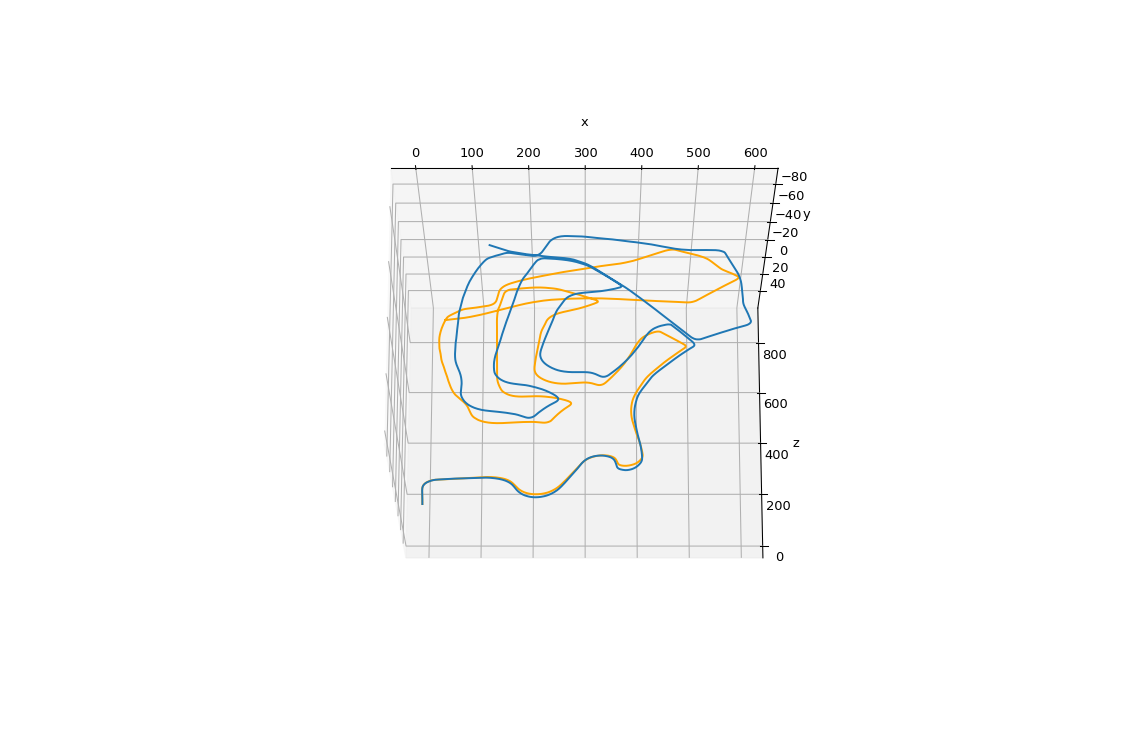

In [69]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_bm[:, :, 3][:, 0], 
        trajectory_nolidar_bm[:, :, 3][:, 1], 
        trajectory_nolidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [70]:
calculate_error(handler.gt, trajectory_nolidar_bm, 'all')


{'mae': 50.69206348100899, 'rmse': 62.34278295009286, 'mse': 3886.622585962389}

In [71]:
# See what kind of results we get without using LIDAR correction on depth
handler.lidar = True
start = datetime.datetime.now()
trajectory_lidar_bm = visual_odometry(handler,
                                      filter_match_distance=0.5, 
                                      detector='sift',
                                      #matching='FLANN',
                                      stereo_matcher='sgbm',
                                      mask=mask,     
                                      subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.222009
Time to compute frame 2: 0:00:00.204811
Time to compute frame 3: 0:00:00.190061
Time to compute frame 4: 0:00:00.205136
Time to compute frame 5: 0:00:00.188897
Time to compute frame 6: 0:00:00.197504
Time to compute frame 7: 0:00:00.204646
Time to compute frame 8: 0:00:00.176346
Time to compute frame 9: 0:00:00.202850
Time to compute frame 10: 0:00:00.188191
Time to compute frame 11: 0:00:00.198205
Time to compute frame 12: 0:00:00.187939
Time to compute frame 13: 0:00:00.205195
Time to compute frame 14: 0:00:00.188129
Time to compute frame 15: 0:00:00.205225
Time to compute frame 16: 0:00:00.189291
Time to compute frame 17: 0:00:00.189970
Time to compute frame 18: 0:00:00.189105
Time to compute frame 19: 0:00:00.213522
Time to compute frame 20: 0:00:00.20

Time to compute frame 195: 0:00:00.251459
Time to compute frame 196: 0:00:00.235322
Time to compute frame 197: 0:00:00.250767
Time to compute frame 198: 0:00:00.251085
Time to compute frame 199: 0:00:00.243099
Time to compute frame 200: 0:00:00.244448
Time to compute frame 201: 0:00:00.235444
Time to compute frame 202: 0:00:00.221401
Time to compute frame 203: 0:00:00.234856
Time to compute frame 204: 0:00:00.215357
Time to compute frame 205: 0:00:00.209141
Time to compute frame 206: 0:00:00.251546
Time to compute frame 207: 0:00:00.220321
Time to compute frame 208: 0:00:00.220024
Time to compute frame 209: 0:00:00.204420
Time to compute frame 210: 0:00:00.223781
Time to compute frame 211: 0:00:00.204607
Time to compute frame 212: 0:00:00.205103
Time to compute frame 213: 0:00:00.212351
Time to compute frame 214: 0:00:00.203663
Time to compute frame 215: 0:00:00.212876
Time to compute frame 216: 0:00:00.225771
Time to compute frame 217: 0:00:00.199535
Time to compute frame 218: 0:00:00

Time to compute frame 391: 0:00:00.274550
Time to compute frame 392: 0:00:00.251835
Time to compute frame 393: 0:00:00.283142
Time to compute frame 394: 0:00:00.266913
Time to compute frame 395: 0:00:00.266795
Time to compute frame 396: 0:00:00.267529
Time to compute frame 397: 0:00:00.314466
Time to compute frame 398: 0:00:00.313917
Time to compute frame 399: 0:00:00.267728
Time to compute frame 400: 0:00:00.266775
Time to compute frame 401: 0:00:00.267294
Time to compute frame 402: 0:00:00.267523
Time to compute frame 403: 0:00:00.251036
Time to compute frame 404: 0:00:00.251145
Time to compute frame 405: 0:00:00.251468
Time to compute frame 406: 0:00:00.266309
Time to compute frame 407: 0:00:00.283196
Time to compute frame 408: 0:00:00.250789
Time to compute frame 409: 0:00:00.251097
Time to compute frame 410: 0:00:00.260963
Time to compute frame 411: 0:00:00.266110
Time to compute frame 412: 0:00:00.270575
Time to compute frame 413: 0:00:00.294639
Time to compute frame 414: 0:00:00

Time to compute frame 587: 0:00:00.298979
Time to compute frame 588: 0:00:00.317953
Time to compute frame 589: 0:00:00.329875
Time to compute frame 590: 0:00:00.304938
Time to compute frame 591: 0:00:00.312860
Time to compute frame 592: 0:00:00.292351
Time to compute frame 593: 0:00:00.296565
Time to compute frame 594: 0:00:00.302481
Time to compute frame 595: 0:00:00.287796
Time to compute frame 596: 0:00:00.335248
Time to compute frame 597: 0:00:00.294819
Time to compute frame 598: 0:00:00.335385
Time to compute frame 599: 0:00:00.316323
Time to compute frame 600: 0:00:00.293442
Time to compute frame 601: 0:00:00.306684
Time to compute frame 602: 0:00:00.280797
Time to compute frame 603: 0:00:00.332466
Time to compute frame 604: 0:00:00.337810
Time to compute frame 605: 0:00:00.295258
Time to compute frame 606: 0:00:00.271842
Time to compute frame 607: 0:00:00.288928
Time to compute frame 608: 0:00:00.323213
Time to compute frame 609: 0:00:00.311555
Time to compute frame 610: 0:00:00

Time to compute frame 783: 0:00:00.279989
Time to compute frame 784: 0:00:00.256281
Time to compute frame 785: 0:00:00.272289
Time to compute frame 786: 0:00:00.272175
Time to compute frame 787: 0:00:00.273236
Time to compute frame 788: 0:00:00.264640
Time to compute frame 789: 0:00:00.281809
Time to compute frame 790: 0:00:00.265344
Time to compute frame 791: 0:00:00.248452
Time to compute frame 792: 0:00:00.248302
Time to compute frame 793: 0:00:00.240199
Time to compute frame 794: 0:00:00.240380
Time to compute frame 795: 0:00:00.249007
Time to compute frame 796: 0:00:00.232481
Time to compute frame 797: 0:00:00.244587
Time to compute frame 798: 0:00:00.271632
Time to compute frame 799: 0:00:00.241000
Time to compute frame 800: 0:00:00.240400
Time to compute frame 801: 0:00:00.225312
Time to compute frame 802: 0:00:00.249793
Time to compute frame 803: 0:00:00.231380
Time to compute frame 804: 0:00:00.225734
Time to compute frame 805: 0:00:00.240261
Time to compute frame 806: 0:00:00

Time to compute frame 979: 0:00:00.279443
Time to compute frame 980: 0:00:00.251098
Time to compute frame 981: 0:00:00.267058
Time to compute frame 982: 0:00:00.281271
Time to compute frame 983: 0:00:00.280207
Time to compute frame 984: 0:00:00.284655
Time to compute frame 985: 0:00:00.266459
Time to compute frame 986: 0:00:00.267842
Time to compute frame 987: 0:00:00.251356
Time to compute frame 988: 0:00:00.288966
Time to compute frame 989: 0:00:00.245273
Time to compute frame 990: 0:00:00.267668
Time to compute frame 991: 0:00:00.256173
Time to compute frame 992: 0:00:00.249350
Time to compute frame 993: 0:00:00.253413
Time to compute frame 994: 0:00:00.256955
Time to compute frame 995: 0:00:00.254097
Time to compute frame 996: 0:00:00.250663
Time to compute frame 997: 0:00:00.265176
Time to compute frame 998: 0:00:00.268290
Time to compute frame 999: 0:00:00.295538
Time to compute frame 1000: 0:00:00.259446
Time to compute frame 1001: 0:00:00.252772
Time to compute frame 1002: 0:00

Time to compute frame 1171: 0:00:00.234896
Time to compute frame 1172: 0:00:00.253914
Time to compute frame 1173: 0:00:00.264405
Time to compute frame 1174: 0:00:00.236179
Time to compute frame 1175: 0:00:00.235190
Time to compute frame 1176: 0:00:00.251779
Time to compute frame 1177: 0:00:00.220031
Time to compute frame 1178: 0:00:00.251220
Time to compute frame 1179: 0:00:00.251179
Time to compute frame 1180: 0:00:00.219641
Time to compute frame 1181: 0:00:00.244117
Time to compute frame 1182: 0:00:00.212019
Time to compute frame 1183: 0:00:00.251795
Time to compute frame 1184: 0:00:00.251231
Time to compute frame 1185: 0:00:00.257803
Time to compute frame 1186: 0:00:00.229531
Time to compute frame 1187: 0:00:00.236101
Time to compute frame 1188: 0:00:00.235442
Time to compute frame 1189: 0:00:00.219996
Time to compute frame 1190: 0:00:00.219653
Time to compute frame 1191: 0:00:00.250838
Time to compute frame 1192: 0:00:00.219628
Time to compute frame 1193: 0:00:00.235293
Time to com

Time to compute frame 1362: 0:00:00.219608
Time to compute frame 1363: 0:00:00.220170
Time to compute frame 1364: 0:00:00.219950
Time to compute frame 1365: 0:00:00.219585
Time to compute frame 1366: 0:00:00.220329
Time to compute frame 1367: 0:00:00.239318
Time to compute frame 1368: 0:00:00.231586
Time to compute frame 1369: 0:00:00.236402
Time to compute frame 1370: 0:00:00.266396
Time to compute frame 1371: 0:00:00.253504
Time to compute frame 1372: 0:00:00.233781
Time to compute frame 1373: 0:00:00.235612
Time to compute frame 1374: 0:00:00.252553
Time to compute frame 1375: 0:00:00.218634
Time to compute frame 1376: 0:00:00.250855
Time to compute frame 1377: 0:00:00.251188
Time to compute frame 1378: 0:00:00.275722
Time to compute frame 1379: 0:00:00.243686
Time to compute frame 1380: 0:00:00.266956
Time to compute frame 1381: 0:00:00.251037
Time to compute frame 1382: 0:00:00.298947
Time to compute frame 1383: 0:00:00.266932
Time to compute frame 1384: 0:00:00.275879
Time to com

Time to compute frame 1553: 0:00:00.239148
Time to compute frame 1554: 0:00:00.265943
Time to compute frame 1555: 0:00:00.251346
Time to compute frame 1556: 0:00:00.235272
Time to compute frame 1557: 0:00:00.236436
Time to compute frame 1558: 0:00:00.235642
Time to compute frame 1559: 0:00:00.240000
Time to compute frame 1560: 0:00:00.248173
Time to compute frame 1561: 0:00:00.235829
Time to compute frame 1562: 0:00:00.261494
Time to compute frame 1563: 0:00:00.241799
Time to compute frame 1564: 0:00:00.267956
Time to compute frame 1565: 0:00:00.282698
Time to compute frame 1566: 0:00:00.251395
Time to compute frame 1567: 0:00:00.252555
Time to compute frame 1568: 0:00:00.267439
Time to compute frame 1569: 0:00:00.250979
Time to compute frame 1570: 0:00:00.266168
Time to compute frame 1571: 0:00:00.250715
Time to compute frame 1572: 0:00:00.298731
Time to compute frame 1573: 0:00:00.251000
Time to compute frame 1574: 0:00:00.251329
Time to compute frame 1575: 0:00:00.235825
Time to com

Time to compute frame 1744: 0:00:00.206612
Time to compute frame 1745: 0:00:00.185144
Time to compute frame 1746: 0:00:00.201142
Time to compute frame 1747: 0:00:00.200506
Time to compute frame 1748: 0:00:00.208832
Time to compute frame 1749: 0:00:00.207124
Time to compute frame 1750: 0:00:00.201654
Time to compute frame 1751: 0:00:00.208561
Time to compute frame 1752: 0:00:00.214277
Time to compute frame 1753: 0:00:00.202176
Time to compute frame 1754: 0:00:00.202968
Time to compute frame 1755: 0:00:00.206071
Time to compute frame 1756: 0:00:00.210137
Time to compute frame 1757: 0:00:00.208681
Time to compute frame 1758: 0:00:00.225469
Time to compute frame 1759: 0:00:00.203195
Time to compute frame 1760: 0:00:00.202136
Time to compute frame 1761: 0:00:00.199639
Time to compute frame 1762: 0:00:00.187742
Time to compute frame 1763: 0:00:00.196497
Time to compute frame 1764: 0:00:00.218032
Time to compute frame 1765: 0:00:00.208300
Time to compute frame 1766: 0:00:00.192861
Time to com

Time to compute frame 1935: 0:00:00.267462
Time to compute frame 1936: 0:00:00.283209
Time to compute frame 1937: 0:00:00.266575
Time to compute frame 1938: 0:00:00.266348
Time to compute frame 1939: 0:00:00.283349
Time to compute frame 1940: 0:00:00.276425
Time to compute frame 1941: 0:00:00.274927
Time to compute frame 1942: 0:00:00.258920
Time to compute frame 1943: 0:00:00.267649
Time to compute frame 1944: 0:00:00.266537
Time to compute frame 1945: 0:00:00.266806
Time to compute frame 1946: 0:00:00.267897
Time to compute frame 1947: 0:00:00.266874
Time to compute frame 1948: 0:00:00.282594
Time to compute frame 1949: 0:00:00.283019
Time to compute frame 1950: 0:00:00.283368
Time to compute frame 1951: 0:00:00.286609
Time to compute frame 1952: 0:00:00.300396
Time to compute frame 1953: 0:00:00.277053
Time to compute frame 1954: 0:00:00.289401
Time to compute frame 1955: 0:00:00.260667
Time to compute frame 1956: 0:00:00.283065
Time to compute frame 1957: 0:00:00.266780
Time to com

Time to compute frame 2127: 0:00:00.188263
Time to compute frame 2128: 0:00:00.173446
Time to compute frame 2129: 0:00:00.188685
Time to compute frame 2130: 0:00:00.172385
Time to compute frame 2131: 0:00:00.188573
Time to compute frame 2132: 0:00:00.188612
Time to compute frame 2133: 0:00:00.188759
Time to compute frame 2134: 0:00:00.172688
Time to compute frame 2135: 0:00:00.188613
Time to compute frame 2136: 0:00:00.188022
Time to compute frame 2137: 0:00:00.173315
Time to compute frame 2138: 0:00:00.188527
Time to compute frame 2139: 0:00:00.188116
Time to compute frame 2140: 0:00:00.188751
Time to compute frame 2141: 0:00:00.204037
Time to compute frame 2142: 0:00:00.205751
Time to compute frame 2143: 0:00:00.192257
Time to compute frame 2144: 0:00:00.201633
Time to compute frame 2145: 0:00:00.221731
Time to compute frame 2146: 0:00:00.188342
Time to compute frame 2147: 0:00:00.205660
Time to compute frame 2148: 0:00:00.204828
Time to compute frame 2149: 0:00:00.203648
Time to com

Time to compute frame 2318: 0:00:00.203935
Time to compute frame 2319: 0:00:00.188709
Time to compute frame 2320: 0:00:00.204244
Time to compute frame 2321: 0:00:00.204345
Time to compute frame 2322: 0:00:00.204237
Time to compute frame 2323: 0:00:00.204669
Time to compute frame 2324: 0:00:00.220257
Time to compute frame 2325: 0:00:00.204041
Time to compute frame 2326: 0:00:00.219812
Time to compute frame 2327: 0:00:00.209279
Time to compute frame 2328: 0:00:00.183313
Time to compute frame 2329: 0:00:00.188999
Time to compute frame 2330: 0:00:00.204222
Time to compute frame 2331: 0:00:00.206483
Time to compute frame 2332: 0:00:00.197682
Time to compute frame 2333: 0:00:00.188584
Time to compute frame 2334: 0:00:00.188471
Time to compute frame 2335: 0:00:00.188564
Time to compute frame 2336: 0:00:00.188357
Time to compute frame 2337: 0:00:00.191548
Time to compute frame 2338: 0:00:00.185884
Time to compute frame 2339: 0:00:00.172619
Time to compute frame 2340: 0:00:00.173000
Time to com

Time to compute frame 2509: 0:00:00.224966
Time to compute frame 2510: 0:00:00.217595
Time to compute frame 2511: 0:00:00.204737
Time to compute frame 2512: 0:00:00.204157
Time to compute frame 2513: 0:00:00.222514
Time to compute frame 2514: 0:00:00.203286
Time to compute frame 2515: 0:00:00.219826
Time to compute frame 2516: 0:00:00.203950
Time to compute frame 2517: 0:00:00.221121
Time to compute frame 2518: 0:00:00.202820
Time to compute frame 2519: 0:00:00.219785
Time to compute frame 2520: 0:00:00.220064
Time to compute frame 2521: 0:00:00.220229
Time to compute frame 2522: 0:00:00.220734
Time to compute frame 2523: 0:00:00.203940
Time to compute frame 2524: 0:00:00.204124
Time to compute frame 2525: 0:00:00.235480
Time to compute frame 2526: 0:00:00.188306
Time to compute frame 2527: 0:00:00.204529
Time to compute frame 2528: 0:00:00.204110
Time to compute frame 2529: 0:00:00.188442
Time to compute frame 2530: 0:00:00.204130
Time to compute frame 2531: 0:00:00.205347
Time to com

Time to compute frame 2700: 0:00:00.219995
Time to compute frame 2701: 0:00:00.203966
Time to compute frame 2702: 0:00:00.219556
Time to compute frame 2703: 0:00:00.203981
Time to compute frame 2704: 0:00:00.203953
Time to compute frame 2705: 0:00:00.219669
Time to compute frame 2706: 0:00:00.188452
Time to compute frame 2707: 0:00:00.203943
Time to compute frame 2708: 0:00:00.219615
Time to compute frame 2709: 0:00:00.188200
Time to compute frame 2710: 0:00:00.214201
Time to compute frame 2711: 0:00:00.200529
Time to compute frame 2712: 0:00:00.213564
Time to compute frame 2713: 0:00:00.219916
Time to compute frame 2714: 0:00:00.204341
Time to compute frame 2715: 0:00:00.219915
Time to compute frame 2716: 0:00:00.204098
Time to compute frame 2717: 0:00:00.219436
Time to compute frame 2718: 0:00:00.204027
Time to compute frame 2719: 0:00:00.220128
Time to compute frame 2720: 0:00:00.219779
Time to compute frame 2721: 0:00:00.219840
Time to compute frame 2722: 0:00:00.220750
Time to com

Time to compute frame 2891: 0:00:00.235308
Time to compute frame 2892: 0:00:00.219493
Time to compute frame 2893: 0:00:00.219717
Time to compute frame 2894: 0:00:00.235746
Time to compute frame 2895: 0:00:00.227764
Time to compute frame 2896: 0:00:00.232426
Time to compute frame 2897: 0:00:00.217888
Time to compute frame 2898: 0:00:00.204977
Time to compute frame 2899: 0:00:00.248473
Time to compute frame 2900: 0:00:00.218318
Time to compute frame 2901: 0:00:00.209212
Time to compute frame 2902: 0:00:00.210636
Time to compute frame 2903: 0:00:00.198788
Time to compute frame 2904: 0:00:00.237944
Time to compute frame 2905: 0:00:00.223828
Time to compute frame 2906: 0:00:00.219354
Time to compute frame 2907: 0:00:00.216704
Time to compute frame 2908: 0:00:00.220019
Time to compute frame 2909: 0:00:00.223004
Time to compute frame 2910: 0:00:00.233956
Time to compute frame 2911: 0:00:00.225524
Time to compute frame 2912: 0:00:00.233344
Time to compute frame 2913: 0:00:00.228890
Time to com

Time to compute frame 3082: 0:00:00.219956
Time to compute frame 3083: 0:00:00.235435
Time to compute frame 3084: 0:00:00.243189
Time to compute frame 3085: 0:00:00.247380
Time to compute frame 3086: 0:00:00.253508
Time to compute frame 3087: 0:00:00.250446
Time to compute frame 3088: 0:00:00.254015
Time to compute frame 3089: 0:00:00.235476
Time to compute frame 3090: 0:00:00.236485
Time to compute frame 3091: 0:00:00.235109
Time to compute frame 3092: 0:00:00.252226
Time to compute frame 3093: 0:00:00.269200
Time to compute frame 3094: 0:00:00.235435
Time to compute frame 3095: 0:00:00.268212
Time to compute frame 3096: 0:00:00.227494
Time to compute frame 3097: 0:00:00.243368
Time to compute frame 3098: 0:00:00.235837
Time to compute frame 3099: 0:00:00.226037
Time to compute frame 3100: 0:00:00.229823
Time to compute frame 3101: 0:00:00.220036
Time to compute frame 3102: 0:00:00.251741
Time to compute frame 3103: 0:00:00.244236
Time to compute frame 3104: 0:00:00.243791
Time to com

Time to compute frame 3273: 0:00:00.251611
Time to compute frame 3274: 0:00:00.267111
Time to compute frame 3275: 0:00:00.267265
Time to compute frame 3276: 0:00:00.285823
Time to compute frame 3277: 0:00:00.294135
Time to compute frame 3278: 0:00:00.282659
Time to compute frame 3279: 0:00:00.267411
Time to compute frame 3280: 0:00:00.267175
Time to compute frame 3281: 0:00:00.266101
Time to compute frame 3282: 0:00:00.267260
Time to compute frame 3283: 0:00:00.251548
Time to compute frame 3284: 0:00:00.268084
Time to compute frame 3285: 0:00:00.251275
Time to compute frame 3286: 0:00:00.282700
Time to compute frame 3287: 0:00:00.256744
Time to compute frame 3288: 0:00:00.265112
Time to compute frame 3289: 0:00:00.236185
Time to compute frame 3290: 0:00:00.236196
Time to compute frame 3291: 0:00:00.234922
Time to compute frame 3292: 0:00:00.236092
Time to compute frame 3293: 0:00:00.246846
Time to compute frame 3294: 0:00:00.255960
Time to compute frame 3295: 0:00:00.245379
Time to com

Time to compute frame 3465: 0:00:00.189826
Time to compute frame 3466: 0:00:00.202883
Time to compute frame 3467: 0:00:00.197916
Time to compute frame 3468: 0:00:00.186363
Time to compute frame 3469: 0:00:00.213046
Time to compute frame 3470: 0:00:00.214766
Time to compute frame 3471: 0:00:00.203823
Time to compute frame 3472: 0:00:00.235313
Time to compute frame 3473: 0:00:00.248034
Time to compute frame 3474: 0:00:00.239545
Time to compute frame 3475: 0:00:00.238502
Time to compute frame 3476: 0:00:00.232777
Time to compute frame 3477: 0:00:00.236089
Time to compute frame 3478: 0:00:00.235571
Time to compute frame 3479: 0:00:00.235950
Time to compute frame 3480: 0:00:00.235311
Time to compute frame 3481: 0:00:00.219720
Time to compute frame 3482: 0:00:00.232250
Time to compute frame 3483: 0:00:00.200115
Time to compute frame 3484: 0:00:00.200285
Time to compute frame 3485: 0:00:00.184557
Time to compute frame 3486: 0:00:00.203646
Time to compute frame 3487: 0:00:00.173341
Time to com

Time to compute frame 3656: 0:00:00.203943
Time to compute frame 3657: 0:00:00.188612
Time to compute frame 3658: 0:00:00.221036
Time to compute frame 3659: 0:00:00.203457
Time to compute frame 3660: 0:00:00.203863
Time to compute frame 3661: 0:00:00.219941
Time to compute frame 3662: 0:00:00.219798
Time to compute frame 3663: 0:00:00.203976
Time to compute frame 3664: 0:00:00.204375
Time to compute frame 3665: 0:00:00.203948
Time to compute frame 3666: 0:00:00.188544
Time to compute frame 3667: 0:00:00.204363
Time to compute frame 3668: 0:00:00.204263
Time to compute frame 3669: 0:00:00.172740
Time to compute frame 3670: 0:00:00.188881
Time to compute frame 3671: 0:00:00.188862
Time to compute frame 3672: 0:00:00.204382
Time to compute frame 3673: 0:00:00.188538
Time to compute frame 3674: 0:00:00.188535
Time to compute frame 3675: 0:00:00.195051
Time to compute frame 3676: 0:00:00.181559
Time to compute frame 3677: 0:00:00.204222
Time to compute frame 3678: 0:00:00.188478
Time to com

Time to compute frame 3848: 0:00:00.204071
Time to compute frame 3849: 0:00:00.174877
Time to compute frame 3850: 0:00:00.217689
Time to compute frame 3851: 0:00:00.203962
Time to compute frame 3852: 0:00:00.203948
Time to compute frame 3853: 0:00:00.204099
Time to compute frame 3854: 0:00:00.188450
Time to compute frame 3855: 0:00:00.188604
Time to compute frame 3856: 0:00:00.187927
Time to compute frame 3857: 0:00:00.188703
Time to compute frame 3858: 0:00:00.204369
Time to compute frame 3859: 0:00:00.188554
Time to compute frame 3860: 0:00:00.203964
Time to compute frame 3861: 0:00:00.188327
Time to compute frame 3862: 0:00:00.182399
Time to compute frame 3863: 0:00:00.178533
Time to compute frame 3864: 0:00:00.172985
Time to compute frame 3865: 0:00:00.172714
Time to compute frame 3866: 0:00:00.177700
Time to compute frame 3867: 0:00:00.167714
Time to compute frame 3868: 0:00:00.172797
Time to compute frame 3869: 0:00:00.172845
Time to compute frame 3870: 0:00:00.173088
Time to com

Time to compute frame 4040: 0:00:00.181399
Time to compute frame 4041: 0:00:00.173956
Time to compute frame 4042: 0:00:00.174709
Time to compute frame 4043: 0:00:00.185328
Time to compute frame 4044: 0:00:00.179727
Time to compute frame 4045: 0:00:00.180336
Time to compute frame 4046: 0:00:00.184800
Time to compute frame 4047: 0:00:00.177799
Time to compute frame 4048: 0:00:00.192548
Time to compute frame 4049: 0:00:00.189927
Time to compute frame 4050: 0:00:00.181582
Time to compute frame 4051: 0:00:00.187616
Time to compute frame 4052: 0:00:00.180910
Time to compute frame 4053: 0:00:00.184995
Time to compute frame 4054: 0:00:00.167387
Time to compute frame 4055: 0:00:00.177322
Time to compute frame 4056: 0:00:00.180506
Time to compute frame 4057: 0:00:00.183078
Time to compute frame 4058: 0:00:00.177397
Time to compute frame 4059: 0:00:00.171268
Time to compute frame 4060: 0:00:00.191723
Time to compute frame 4061: 0:00:00.166139
Time to compute frame 4062: 0:00:00.174684
Time to com

Time to compute frame 4232: 0:00:00.210002
Time to compute frame 4233: 0:00:00.219599
Time to compute frame 4234: 0:00:00.235464
Time to compute frame 4235: 0:00:00.267851
Time to compute frame 4236: 0:00:00.270022
Time to compute frame 4237: 0:00:00.269209
Time to compute frame 4238: 0:00:00.266677
Time to compute frame 4239: 0:00:00.235820
Time to compute frame 4240: 0:00:00.283736
Time to compute frame 4241: 0:00:00.219577
Time to compute frame 4242: 0:00:00.251377
Time to compute frame 4243: 0:00:00.266537
Time to compute frame 4244: 0:00:00.220077
Time to compute frame 4245: 0:00:00.224159
Time to compute frame 4246: 0:00:00.220410
Time to compute frame 4247: 0:00:00.219722
Time to compute frame 4248: 0:00:00.229110
Time to compute frame 4249: 0:00:00.217786
Time to compute frame 4250: 0:00:00.217321
Time to compute frame 4251: 0:00:00.220761
Time to compute frame 4252: 0:00:00.227159
Time to compute frame 4253: 0:00:00.232261
Time to compute frame 4254: 0:00:00.220494
Time to com

Time to compute frame 4423: 0:00:00.203238
Time to compute frame 4424: 0:00:00.201568
Time to compute frame 4425: 0:00:00.194808
Time to compute frame 4426: 0:00:00.215256
Time to compute frame 4427: 0:00:00.226218
Time to compute frame 4428: 0:00:00.228568
Time to compute frame 4429: 0:00:00.213568
Time to compute frame 4430: 0:00:00.226553
Time to compute frame 4431: 0:00:00.212410
Time to compute frame 4432: 0:00:00.224406
Time to compute frame 4433: 0:00:00.227898
Time to compute frame 4434: 0:00:00.233377
Time to compute frame 4435: 0:00:00.213717
Time to compute frame 4436: 0:00:00.200545
Time to compute frame 4437: 0:00:00.214446
Time to compute frame 4438: 0:00:00.204065
Time to compute frame 4439: 0:00:00.205068
Time to compute frame 4440: 0:00:00.210707
Time to compute frame 4441: 0:00:00.227993
Time to compute frame 4442: 0:00:00.196247
Time to compute frame 4443: 0:00:00.188342
Time to compute frame 4444: 0:00:00.189438
Time to compute frame 4445: 0:00:00.214550
Time to com

Time to compute frame 4614: 0:00:00.237776
Time to compute frame 4615: 0:00:00.220833
Time to compute frame 4616: 0:00:00.211704
Time to compute frame 4617: 0:00:00.242658
Time to compute frame 4618: 0:00:00.226599
Time to compute frame 4619: 0:00:00.223763
Time to compute frame 4620: 0:00:00.197547
Time to compute frame 4621: 0:00:00.231619
Time to compute frame 4622: 0:00:00.241721
Time to compute frame 4623: 0:00:00.215087
Time to compute frame 4624: 0:00:00.211681
Time to compute frame 4625: 0:00:00.206120
Time to compute frame 4626: 0:00:00.203718
Time to compute frame 4627: 0:00:00.198636
Time to compute frame 4628: 0:00:00.227721
Time to compute frame 4629: 0:00:00.239315
Time to compute frame 4630: 0:00:00.207566
Time to compute frame 4631: 0:00:00.221193
Time to compute frame 4632: 0:00:00.189711
Time to compute frame 4633: 0:00:00.217377
Time to compute frame 4634: 0:00:00.182368
Time to compute frame 4635: 0:00:00.236564
Time to compute frame 4636: 0:00:00.186409
Time to com

In [72]:
%matplotlib notebook

<IPython.core.display.Javascript object>


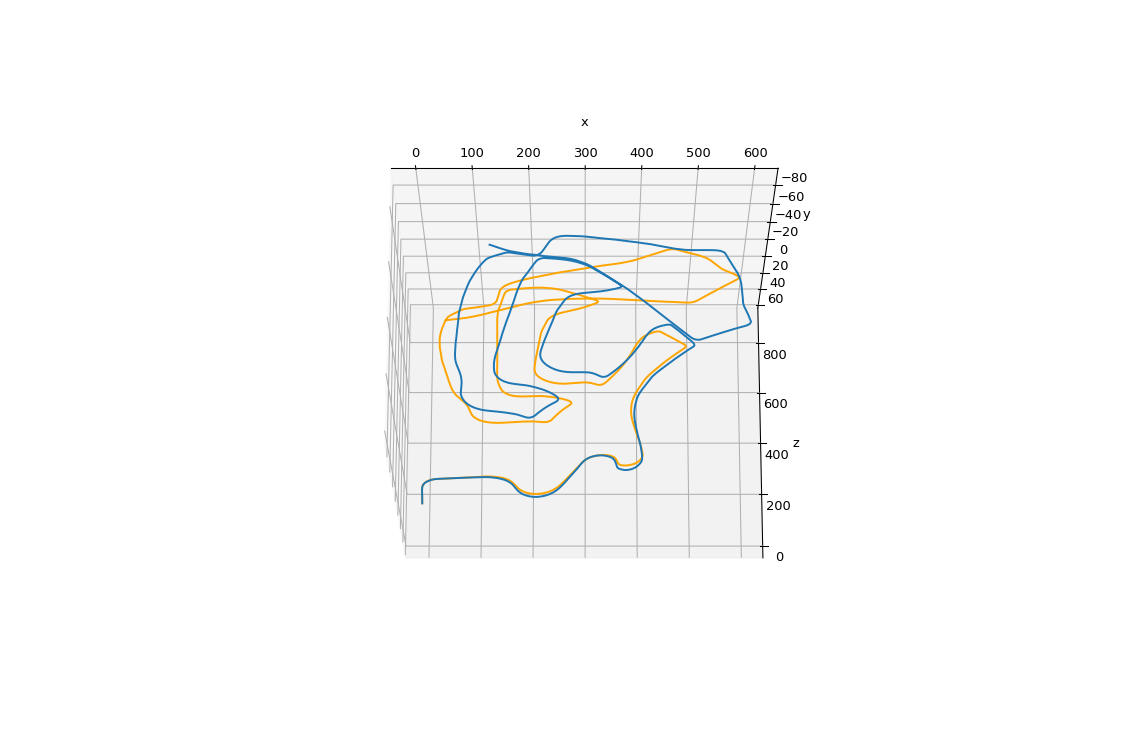

In [73]:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_lidar_bm[:, :, 3][:, 0], 
        trajectory_lidar_bm[:, :, 3][:, 1], 
        trajectory_lidar_bm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)


In [74]:
calculate_error(handler.gt, trajectory_lidar_bm, 'all')

{'mae': 50.65598853114764,
 'rmse': 62.26798451041466,
 'mse': 3877.3018949892394}